# Assignment 2 - February Group

In [152]:
# Install Packages
install.packages("quanteda")
install.packages("textclean")
install.packages("ggrepel")
install.packages("glmnet")
install.packages("pROC")

# Run libraries
library(quanteda)
library(ggrepel)
library(textclean)
library(tidyverse)
library(glmnet)
library(pROC)


The downloaded binary packages are in
	/var/folders/by/g895l7l128j9y19qqn66xcxh0000gn/T//RtmptsSQOJ/downloaded_packages

The downloaded binary packages are in
	/var/folders/by/g895l7l128j9y19qqn66xcxh0000gn/T//RtmptsSQOJ/downloaded_packages

The downloaded binary packages are in
	/var/folders/by/g895l7l128j9y19qqn66xcxh0000gn/T//RtmptsSQOJ/downloaded_packages

The downloaded binary packages are in
	/var/folders/by/g895l7l128j9y19qqn66xcxh0000gn/T//RtmptsSQOJ/downloaded_packages

The downloaded binary packages are in
	/var/folders/by/g895l7l128j9y19qqn66xcxh0000gn/T//RtmptsSQOJ/downloaded_packages


In [153]:
# Load in scripts

# n-gram converter
source("TMEF_dfm.R")

# Kendall accuracy
source("kendall_acc.R")

# Load in data
glassdoor<-readRDS("glassdoorReviews.RDS")

In [154]:
# List companies in the dataset
head(unique(glassdoor$company))

[1] "google"    "amazon"    "facebook"  "netflix"   "apple"     "microsoft"

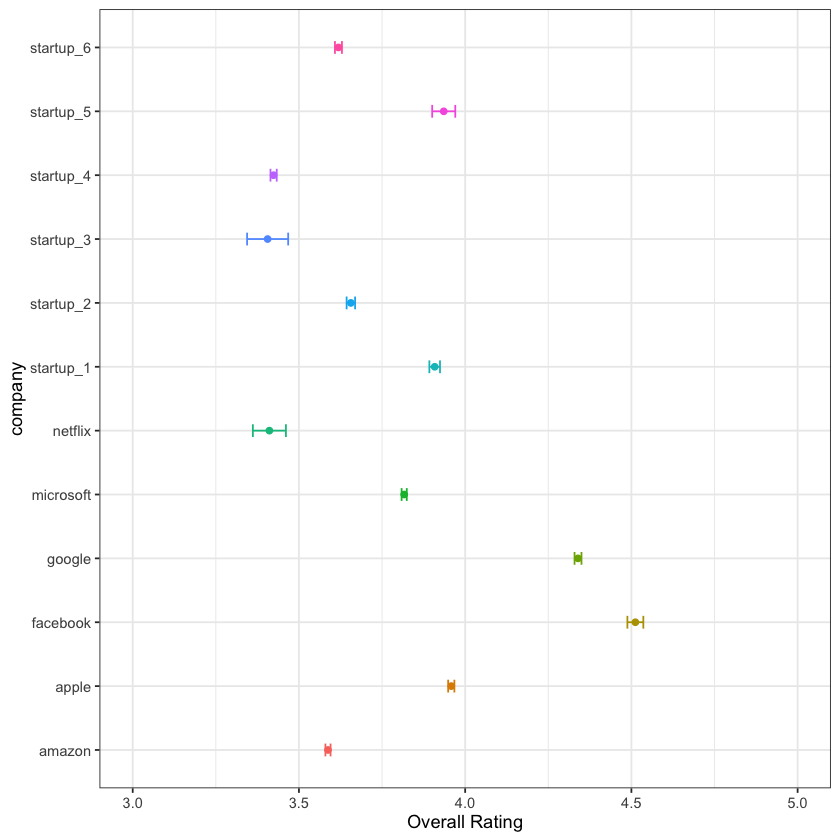

In [155]:
# Overall Rating of Each Company

overall_avgs %>%
  ggplot(aes(x=company,color=company,
             y=m,ymin=m-se,ymax=m+se)) +
  geom_point() +
  geom_errorbar(width=.2) +
  theme_bw() +
  coord_flip() + # coord_flip makes the axis labels readable!
  scale_y_continuous(limits = c(3,5)) +
  labs(y="Overall Rating")+
  theme(legend.position="none")

Warning message:
“Removed 2038 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”
Warning message:
“Removed 5258 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


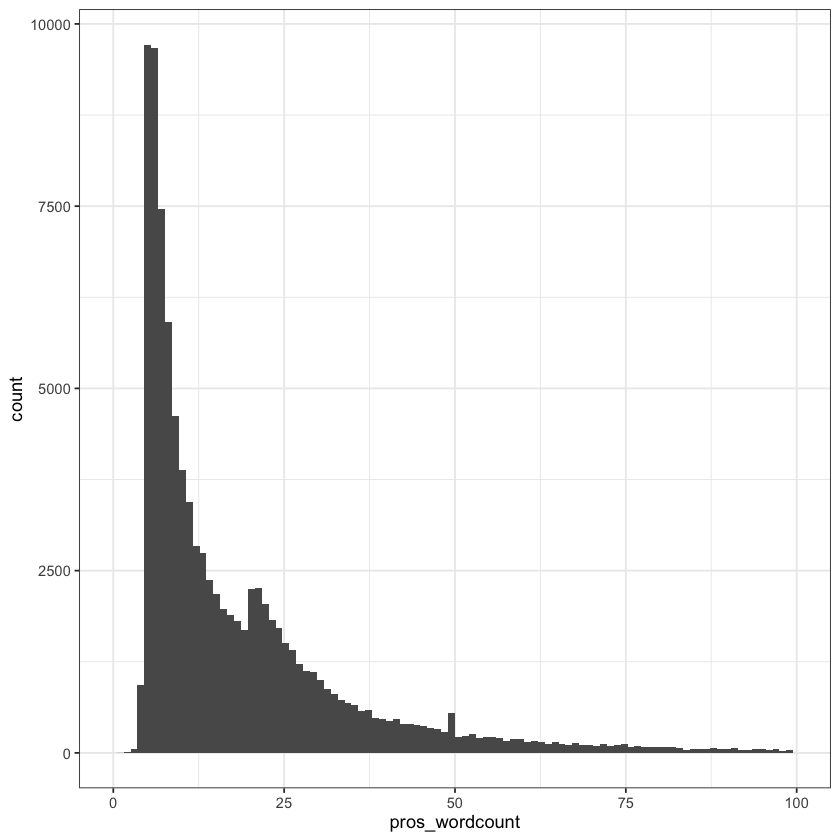

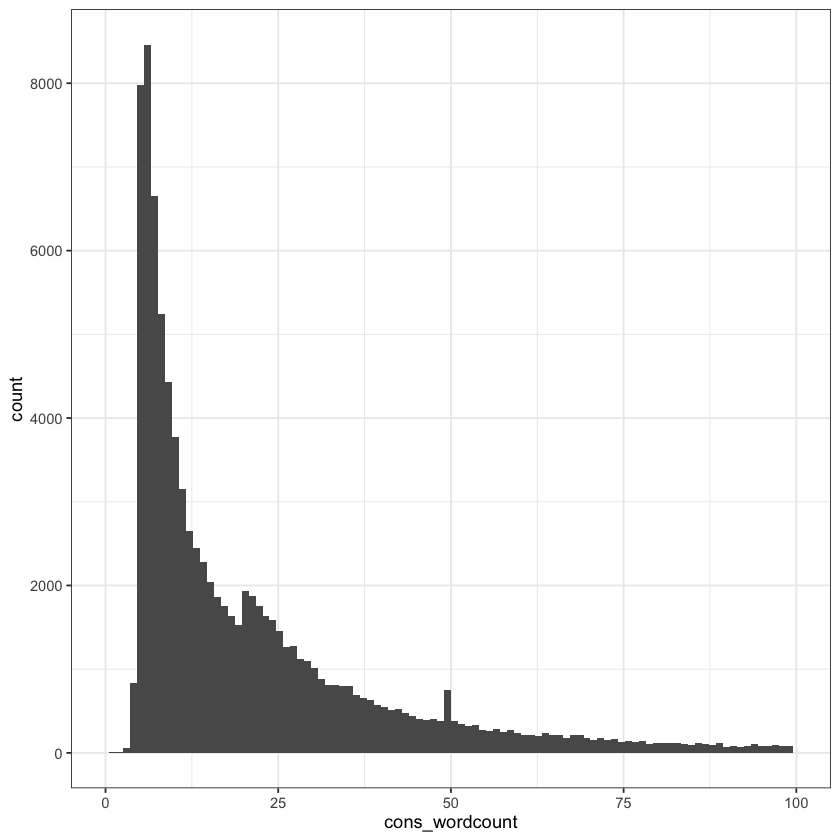

In [156]:
# Distribution of number of words in the dataset

# We segregate the histograms into pros and cons 
glassdoor <- glassdoor%>%
  mutate(pros_wordcount=str_count(pros,"[[:alpha:]]+"),
         cons_wordcount=str_count(cons,"[[:alpha:]]+"))

glassdoor %>%
  ggplot(aes(x=pros_wordcount)) +
  geom_histogram(bins = 100) +
  theme_bw() +
  xlim(0,100)

glassdoor %>%
  ggplot(aes(x=cons_wordcount)) +
  geom_histogram(bins = 100) +
  theme_bw() +
  xlim(0,100)

In [157]:
# Let's focus on people who actually wrote text in both boxes

gd_small<-glassdoor %>%
  filter(pros_wordcount>5 & cons_wordcount>5) # removes reviews that is less than 5 words

dim(gd_small)
# Even that's too big so let's get it down to 40,000 texts

# Before we randomise, use set.seed() to all get the same split
set.seed(0202) 

# Grab the first 40,000 rows after randomizing
gd_small<-gd_small %>%
  arrange(sample(1:n())) %>%
  slice(1:40000)

[1] 81116    19

In [158]:
# Split into train and test set
train_split=sample(1:nrow(gd_small),20000)

gd_train<-gd_small%>%
  slice(train_split)

gd_test<-gd_small%>%
  slice(-train_split)

## Question 1 - Why is the ngram model so much more accurate on the pros data than the cons data?

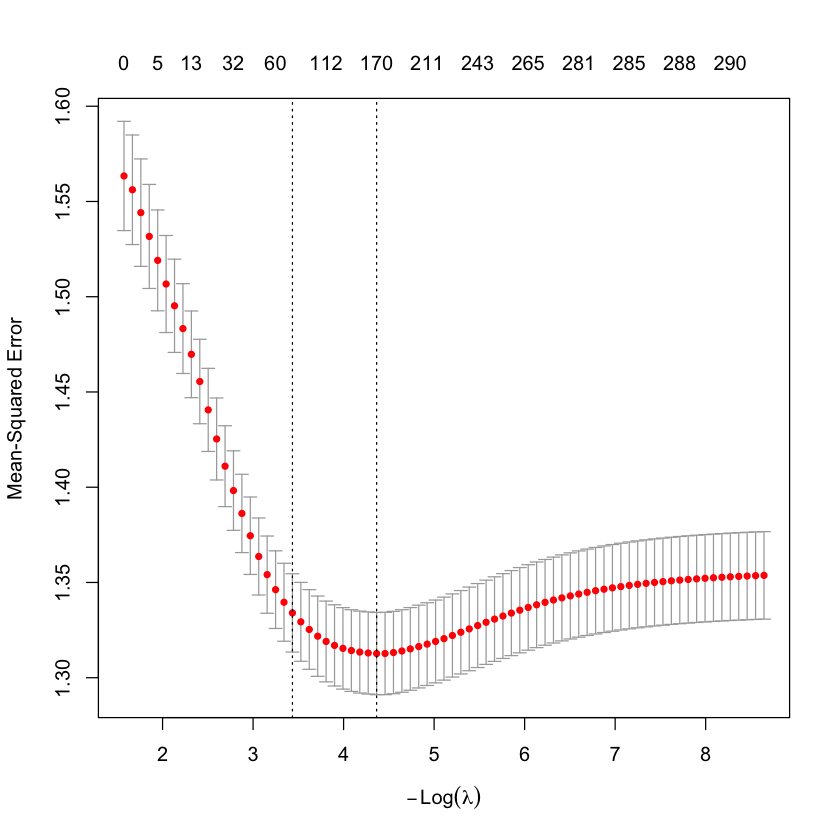

In [159]:
# Filtering for Amazon data

gd_amazon_train<-gd_train %>%
  filter(company=="amazon")

gd_amazon_test<-gd_test %>%
  filter(company=="amazon")

dfm_amazon_train_pros<-TMEF_dfm(gd_amazon_train$pros,ngrams=1:2) %>%
  convert(to="matrix")

amazon_train_Y<-gd_amazon_train %>%
  pull(overall)

# Put training data into LASSO model

amazon_model_pros<-cv.glmnet(x=dfm_amazon_train_pros,
                             y=amazon_train_Y)

# Check the tuning to see if there is useful information
plot(amazon_model_pros)


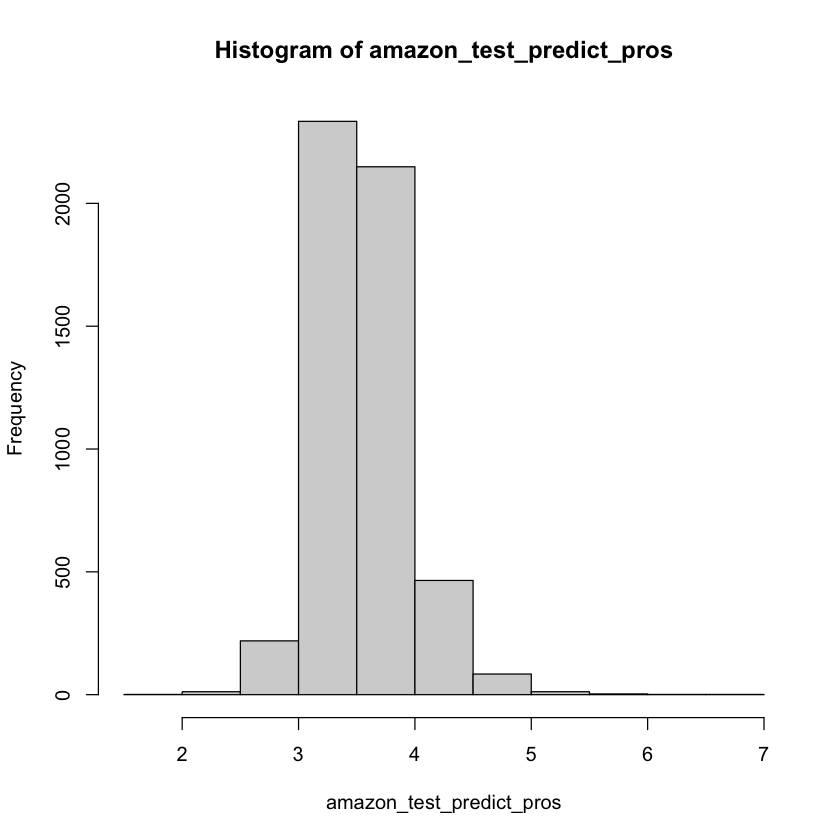

acc,lower,upper
<dbl>,<dbl>,<dbl>
65.26,63.97,66.54


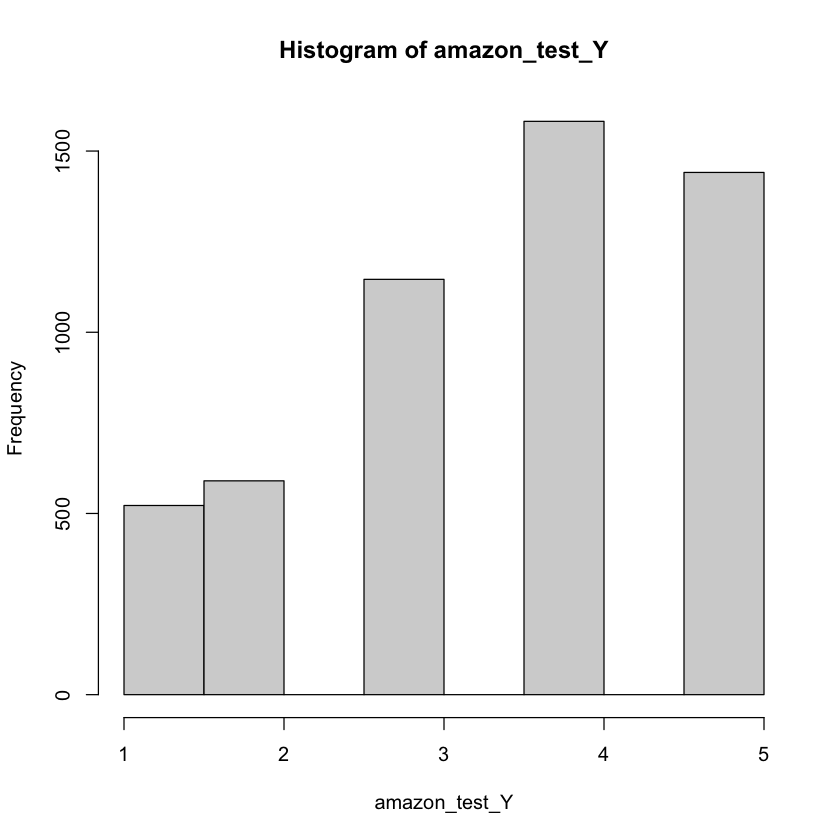

In [160]:
# Test the model on the pros text from amazon
dfm_amazon_test_pros<-TMEF_dfm(gd_amazon_test$pros,
                               ngrams=1:2,
                               min.prop = 0) %>%
  dfm_match(colnames(dfm_amazon_train_pros)) %>% # this matches the column names in the test and training set
  convert(to="matrix")

amazon_test_Y<-gd_amazon_test %>%
  pull(overall)

# Generate predictions for test data
amazon_test_predict_pros<-predict(amazon_model_pros,
                                  newx = dfm_amazon_test_pros)[,1]

# Check distributions - continuous predictor, continuous outcome
hist(amazon_test_predict_pros)
hist(amazon_test_Y)

# Estimate accuracy - use kendall's tau (the function that we created in a separate file)
pros_acc_1<-kendall_acc(amazon_test_predict_pros,amazon_test_Y)

pros_acc_1

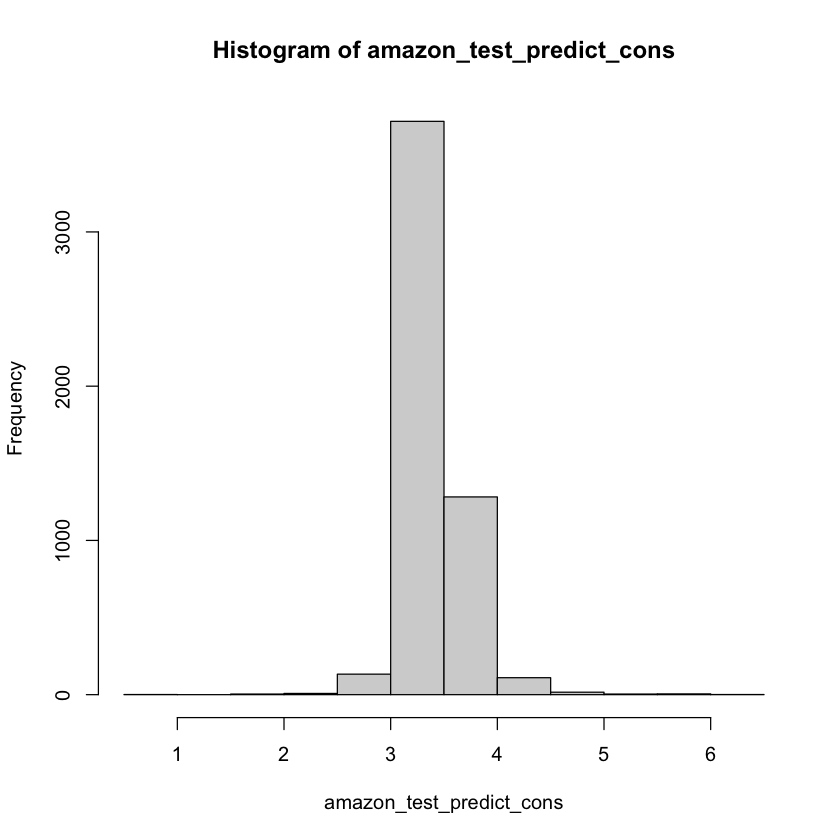

acc,lower,upper
<dbl>,<dbl>,<dbl>
47.45,46.11,48.8


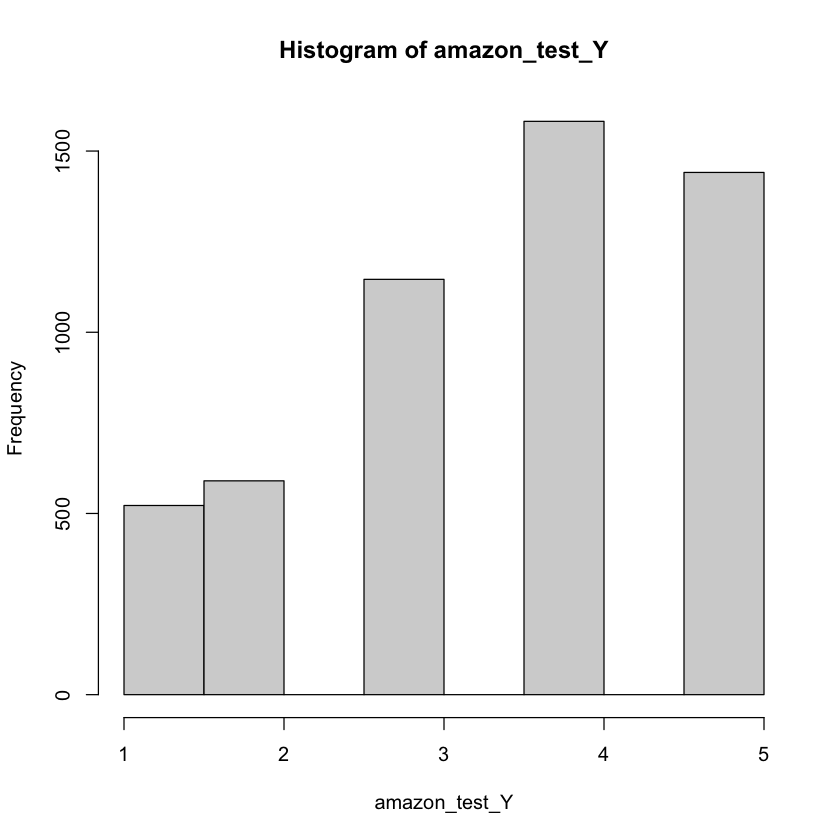

In [161]:
# Applying the same model to the cons text

dfm_amazon_test_cons<-TMEF_dfm(gd_amazon_test$cons,ngrams=1:2, min.prop=0)  %>%
  dfm_match(colnames(dfm_amazon_train_pros)) %>%
  convert(to="matrix")

# Generate predictions for test data
amazon_test_predict_cons<-predict(amazon_model_pros,
                                  newx = dfm_amazon_test_cons)[,1]

hist(amazon_test_predict_cons)
hist(amazon_test_Y)

# Estimate accuracy
cons_acc_1<-kendall_acc(amazon_test_predict_cons,amazon_test_Y)
cons_acc_1

## Question 2 - Model #2, training data on cons text from Amazon

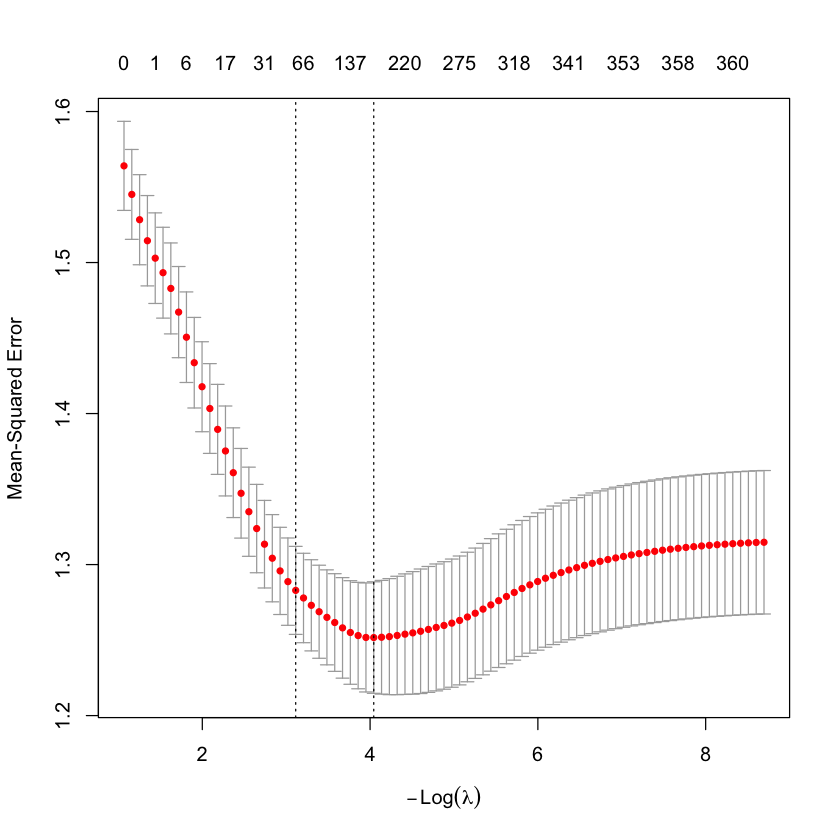

In [162]:
# Second Model - Trained on Cons Text

amazon_train_2<-gd_train %>%
  filter(company=="amazon")

amazon_test_2<-gd_test %>%
  filter(company=="amazon")

amazon_train_cons_df <- dfm_amazon_train_cons
amazon_train_cons_df <- as.data.frame(dfm_amazon_train_cons_df)

dfm_amazon_train_cons<-TMEF_dfm(amazon_train_2$cons,ngrams=1:2) %>%
  convert(to="matrix")

amazon_train_Y<-amazon_train_2 %>%
  pull(overall)

# Put training data into LASSO model

amazon_model_cons<-cv.glmnet(x=dfm_amazon_train_cons,
                             y=amazon_train_Y)

# Check the tuning to see if there is useful information
plot(amazon_model_cons)


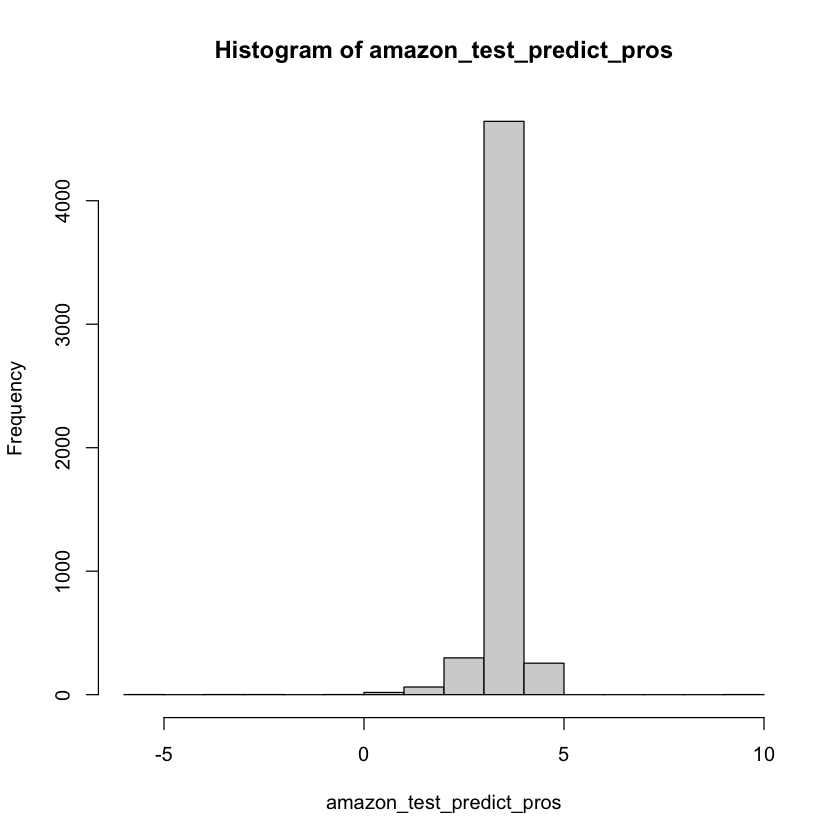

acc,lower,upper
<dbl>,<dbl>,<dbl>
69.89,68.65,71.12


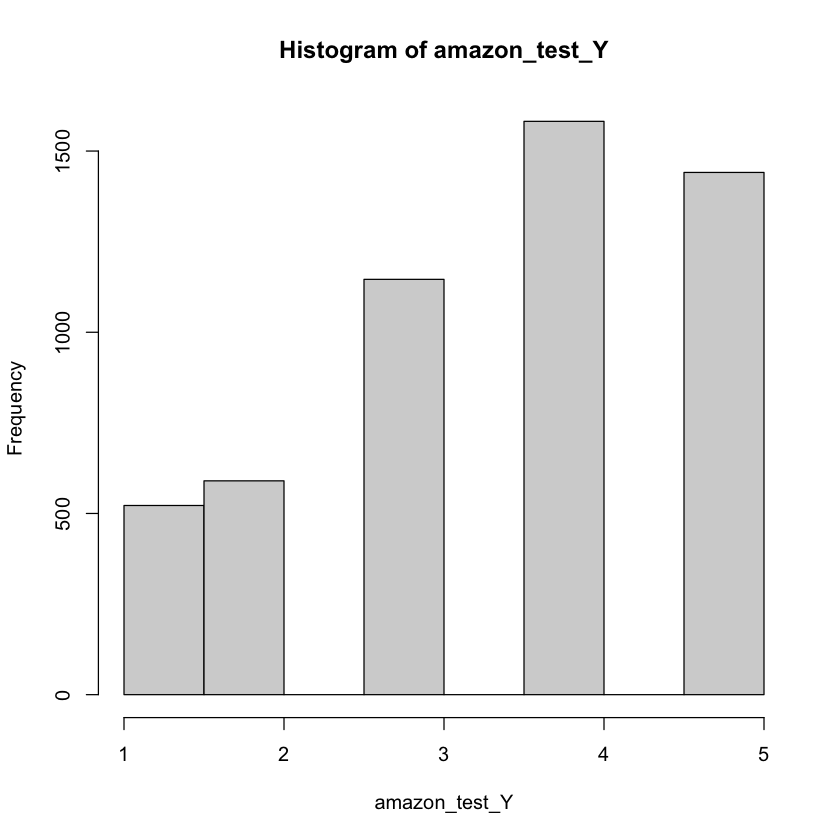

In [163]:
# Test the model on the pros text from amazon
dfm_amazon_test_cons<-TMEF_dfm(gd_amazon_test$cons,
                               ngrams=1:2,
                               min.prop = 0) %>%
  dfm_match(colnames(dfm_amazon_train_cons)) %>% 
  convert(to="matrix")

amazon_test_2<-amazon_test_2 %>%
  pull(overall)

# Generate predictions for test data
amazon_test_predict_pros<-predict(amazon_model_cons,
                                  newx = dfm_amazon_test_cons)[,1]

# Check distributions - continuous predictor, continuous outcome
hist(amazon_test_predict_pros)
hist(amazon_test_Y)

# Estimate accuracy 
pros_acc_2<-kendall_acc(amazon_test_predict_pros,amazon_test_Y)

pros_acc_2

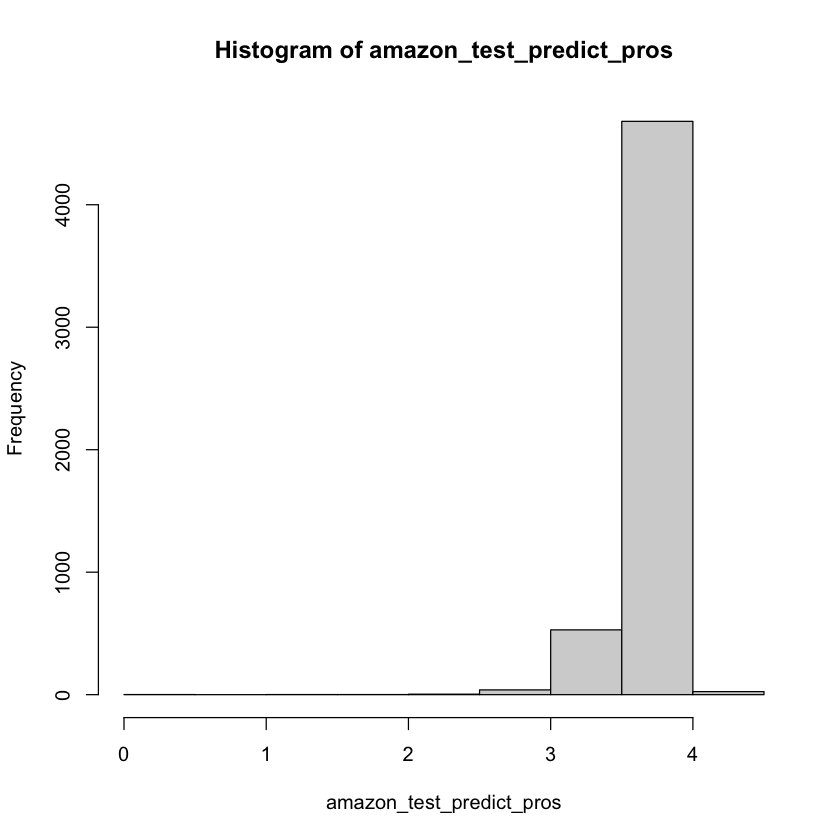

acc,lower,upper
<dbl>,<dbl>,<dbl>
48.35,47,49.7


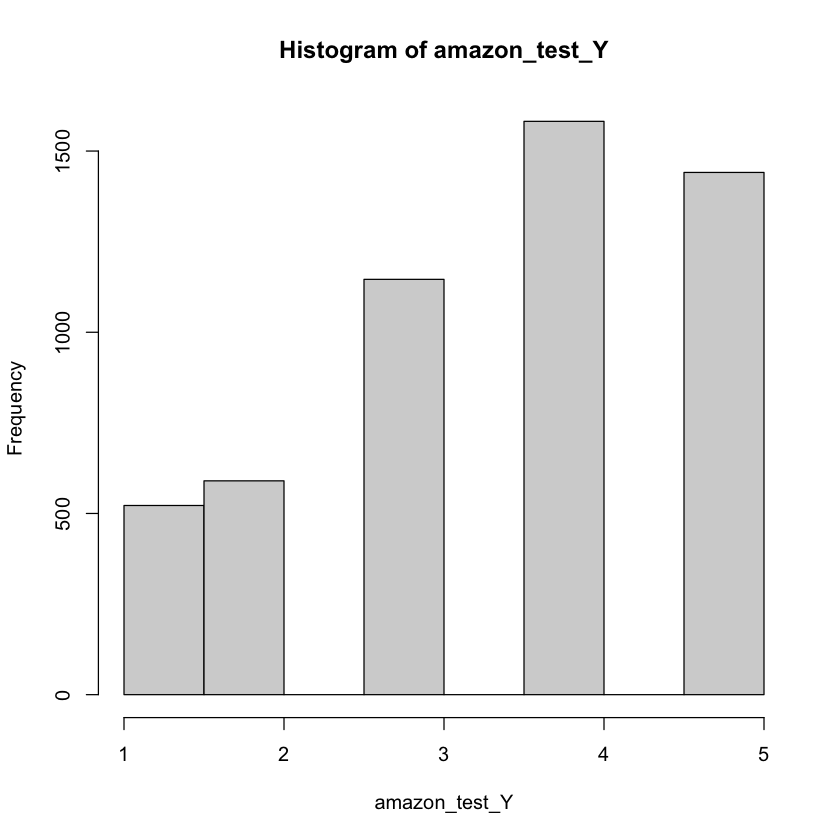

In [164]:
# Applying the same model to the pros text

dfm_amazon_test_pros<-TMEF_dfm(gd_amazon_test$pros,ngrams=1:2, min.prop=0)  %>%
  dfm_match(colnames(dfm_amazon_train_cons)) %>%
  convert(to="matrix")

# Generate predictions for test data
amazon_test_predict_pros<-predict(amazon_model_cons,
                                  newx = dfm_amazon_test_pros)[,1]

hist(amazon_test_predict_pros)
hist(amazon_test_Y)

# Estimate accuracy
cons_acc_2<-kendall_acc(amazon_test_predict_pros,amazon_test_Y)
cons_acc_2

## Question 3 - Accuracy Scores of each model

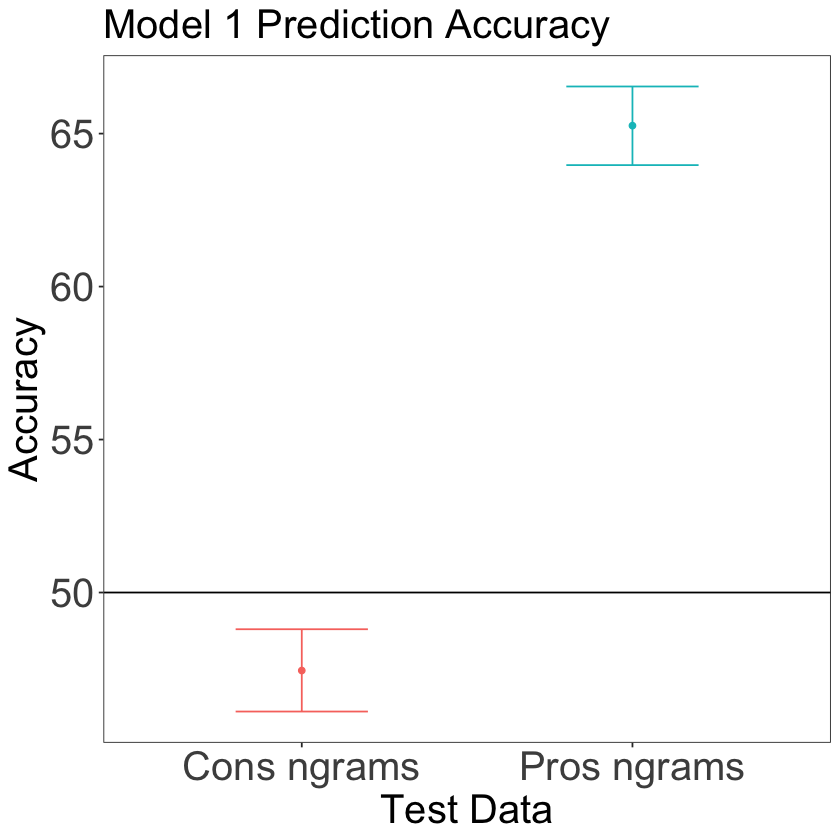

In [165]:
# Combine accuracy estimates for Model 1
bind_rows(pros_acc_1 %>%
            mutate(field="Pros ngrams"),
          cons_acc_1 %>%
            mutate(field="Cons ngrams")) %>%
  ggplot(aes(x=field,color=field,
             y=acc,ymin=lower,ymax=upper)) +
  geom_point() +
  geom_errorbar(width=.4) +
  theme_bw() +
  labs(x="Test Data",y="Accuracy", title="Model 1 Prediction Accuracy") +
  geom_hline(yintercept = 50) +
  theme(axis.text = element_text(size=24),
        axis.title = element_text(size=24),
        plot.title=element_text(size=24),
        panel.grid=element_blank(),
        legend.position="none")

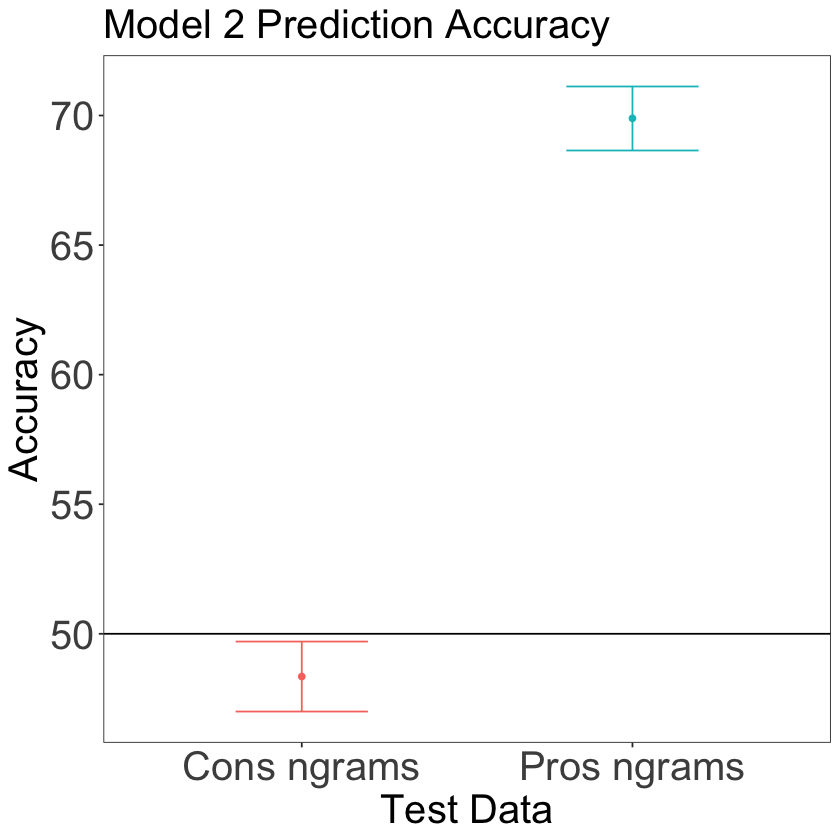

In [166]:
# Combine accuracy estimates for Model 2
bind_rows(pros_acc_2 %>%
            mutate(field="Pros ngrams"),
          cons_acc_2 %>%
            mutate(field="Cons ngrams")) %>%
  ggplot(aes(x=field,color=field,
             y=acc,ymin=lower,ymax=upper)) +
  geom_point() +
  geom_errorbar(width=.4) +
  theme_bw() +
  labs(x="Test Data",y="Accuracy", title="Model 2 Prediction Accuracy") +
  geom_hline(yintercept = 50) +
  theme(axis.text = element_text(size=24),
        axis.title = element_text(size=24),
        plot.title=element_text(size=24),
        panel.grid=element_blank(),
        legend.position="none")

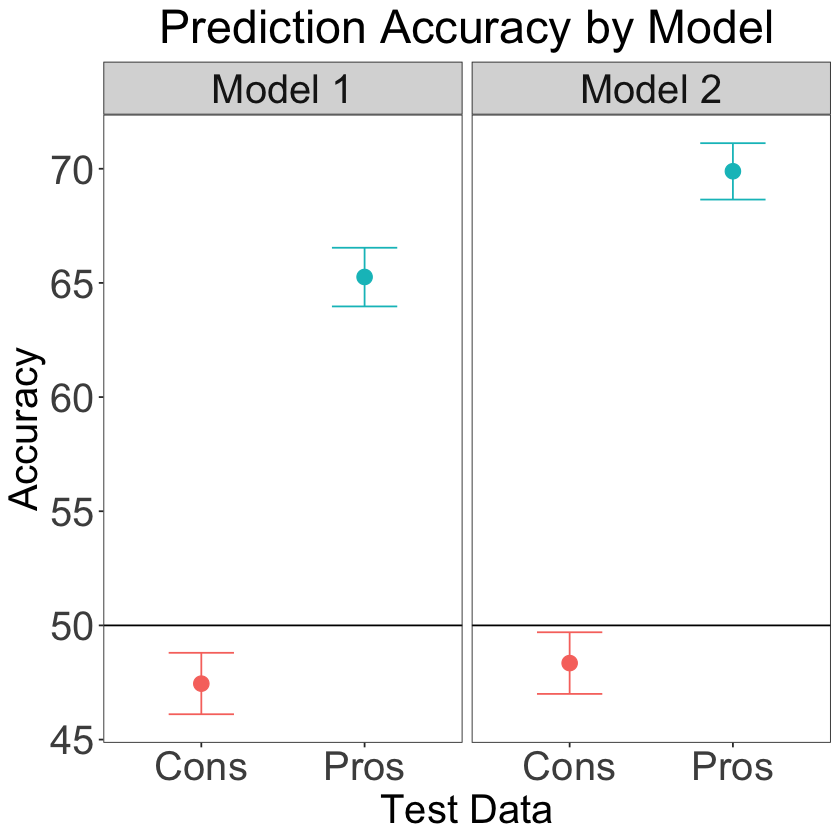

In [167]:
# Com
acc_all <- bind_rows(
  pros_acc_1 %>% mutate(field = "Pros", model = "Model 1"),
  cons_acc_1 %>% mutate(field = "Cons", model = "Model 1"),
  pros_acc_2 %>% mutate(field = "Pros", model = "Model 2"),
  cons_acc_2 %>% mutate(field = "Cons", model = "Model 2")
)

ggplot(acc_all,
       aes(x = field, color = field,
           y = acc, ymin = lower, ymax = upper)) +
  geom_point(size = 4) +
  geom_errorbar(width = .4) +
  geom_hline(yintercept = 50) +
  facet_wrap(~ model) +
  theme_bw() +
  labs(
    x = "Test Data",
    y = "Accuracy",
    title = "Prediction Accuracy by Model"
  ) +
  theme(
    axis.text = element_text(size = 24),
    axis.title = element_text(size = 24),
    plot.title = element_text(size = 28, hjust = 0.5),
    strip.text = element_text(size = 24),  
    panel.grid = element_blank(),
    legend.position = "none"
  )

# Looking at the accuracy plots side-by-side, we find that the second model (which was trained on con words) 
# was generally able to perform better in both pro and con test samples


## Question 4 - ngram coefficient plots 

In [168]:
# Preparing models for n-gram plots
freq_df <- dfm_amazon_test_pros_df %>%
  summarise(across(everything(), mean)) %>%
  pivot_longer(
    cols = everything(),
    names_to = "ngram",
    values_to = "freq"
  )

coef_df <- coef(amazon_model_pros, s = "lambda.min") %>%
  as.matrix() %>%
  as.data.frame() %>%
  tibble::rownames_to_column("ngram") %>%
  rename(score = s0)

plotDat <- freq_df %>%
  inner_join(coef_df, by = "ngram")

ERROR: Error: object 'dfm_amazon_test_pros_df' not found


### N-gram coefficient plot for Model 1

In [ ]:
# Reorder test columns to match train exactly
dfm_amazon_test_pros <- dfm_amazon_test_pros[, train_terms, drop = FALSE]


# Extract non-zero coefficients from trained model
plotCoefs <- coef(amazon_model_pros, s = s_lambda) %>%
  as.matrix() %>%
  as.data.frame() %>%
  rownames_to_column("ngram")

# Rename the coefficient column robustly (whatever it's called) -> "score"
names(plotCoefs)[names(plotCoefs) != "ngram"] <- "score"

plotCoefs <- plotCoefs %>%
  filter(
    ngram != "(Intercept)",
    !is.na(score),
    score != 0
  )

# Compute test frequencies ("uses per review")
plotFreqs <- data.frame(
  ngram = colnames(dfm_amazon_test_pros),
  freq  = colMeans(dfm_amazon_test_pros)
)

# 6) Combine + round
plotDat <- plotCoefs %>%
  inner_join(plotFreqs, by = "ngram") %>%   # only keep terms present in both (they should be)
  mutate(across(c(score, freq), ~ round(., 3)))

head(plotDat)


,ngram,score,freq
,<chr>,<dbl>,<dbl>
1,peopl,-0.021,0.223
2,mani,0.010,0.047
3,learn,0.031,0.151
4,pros,-0.746,0.010
5,doe,-0.010,0.014
6,right,0.047,0.016


Warning message in scale_y_continuous(trans = "log2", breaks = c(0.01, 0.05, 0.1, :
“log-2 transformation introduced infinite values.”
Warning message in scale_y_continuous(trans = "log2", breaks = c(0.01, 0.05, 0.1, :
“log-2 transformation introduced infinite values.”
Warning message:
“Removed 56 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 56 rows containing missing values or values outside the scale range
(`geom_label_repel()`).”
Warning message:
“ggrepel: 34 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


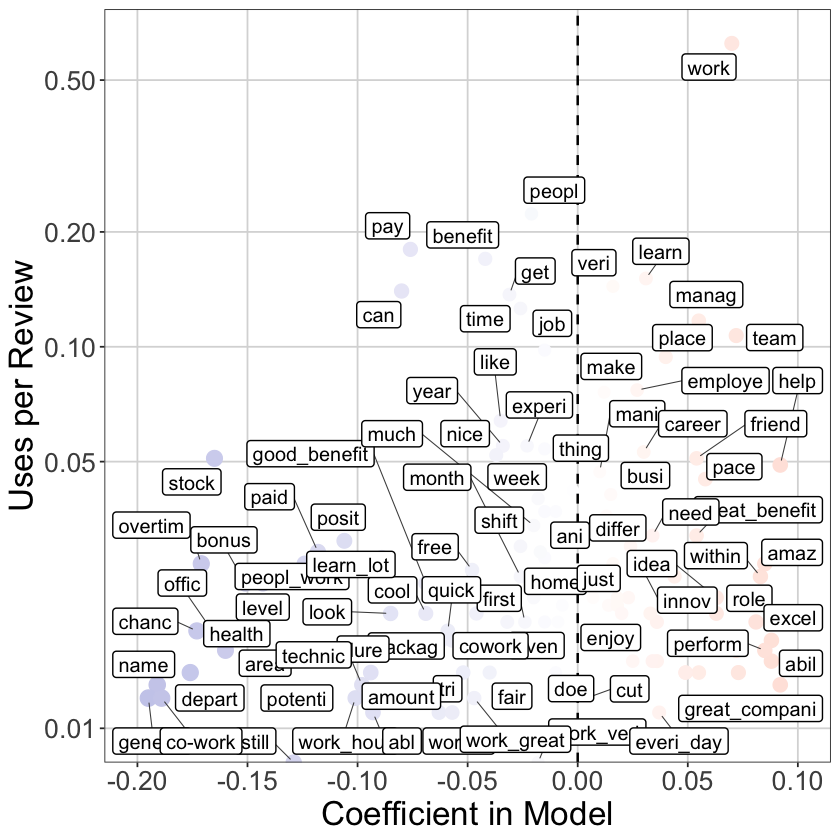

In [ ]:
plotDat %>%
  ggplot(aes(x = score, y = freq)) +

  # points: keep colourful
  geom_point(aes(color = score, size = abs(score)),
             alpha = 1) +

  scale_color_gradient2(
    low  = "#0050B3",
    mid  = "white",
    high = "#D40000",
    midpoint = 0
  ) +
  scale_size_continuous(range = c(2.5, 6)) +
  guides(size = "none", color = "none") +

  geom_vline(xintercept = 0, linetype = "dashed", linewidth = 0.7) +

  # labels: force readable styling (no colour mapping, no transparency)
  ggrepel::geom_label_repel(
    aes(label = ngram),
    color = "black",        # text colour
    fill  = "white",        # label background
    alpha = 1,              # label opacity
    label.size = 0.4,       # border thickness
    size = 4.2,             # text size (try 4–5)
    box.padding = 0.35,
    point.padding = 0.25,
    segment.color = "grey30",
    segment.size = 0.3,
    max.overlaps = 15
  ) +

  scale_x_continuous(
    limits = c(-.2, .1),
    breaks = seq(-.2, .2, .05)
  ) +
  scale_y_continuous(
    trans = "log2",
    breaks = c(.01, .05, .1, .2, .5, 1, 2, 5)
  ) +

  theme_bw() +
  labs(x = "Coefficient in Model", y = "Uses per Review") +
  theme(
    axis.title = element_text(size = 20),
    axis.text  = element_text(size = 16),
    panel.grid.major = element_line(color = "grey85"),
    panel.grid.minor = element_blank()
  )


### N-gram coefficient plot for Model 2

In [170]:
# Extract non-zero coefficients from trained model
plotCoefs <- coef(amazon_model_cons, s = s_lambda) %>%
  as.matrix() %>%
  as.data.frame() %>%
  rownames_to_column("ngram")

# Rename the coefficient column robustly (whatever it's called) -> "score"
names(plotCoefs)[names(plotCoefs) != "ngram"] <- "score"

plotCoefs <- plotCoefs %>%
  filter(
    ngram != "(Intercept)",
    !is.na(score),
    score != 0
  )

# Compute test frequencies ("uses per review")
plotFreqs <- data.frame(
  ngram = colnames(dfm_amazon_test_cons),
  freq  = colMeans(dfm_amazon_test_cons)
)

# 6) Combine + round
plotDat2 <- plotCoefs %>%
  inner_join(plotFreqs, by = "ngram") %>%   # only keep terms present in both (they should be)
  mutate(across(c(score, freq), ~ round(., 3)))

head(plotDat2)


,ngram,score,freq
,<chr>,<dbl>,<dbl>
1,even,-0.076,0.067
2,colleg,-0.118,0.009
3,turn,-0.157,0.014
4,product,-0.013,0.034
5,break,-0.177,0.068
6,like,-0.035,0.126


Warning message:
“Removed 49 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 49 rows containing missing values or values outside the scale range
(`geom_label_repel()`).”
Warning message:
“ggrepel: 26 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


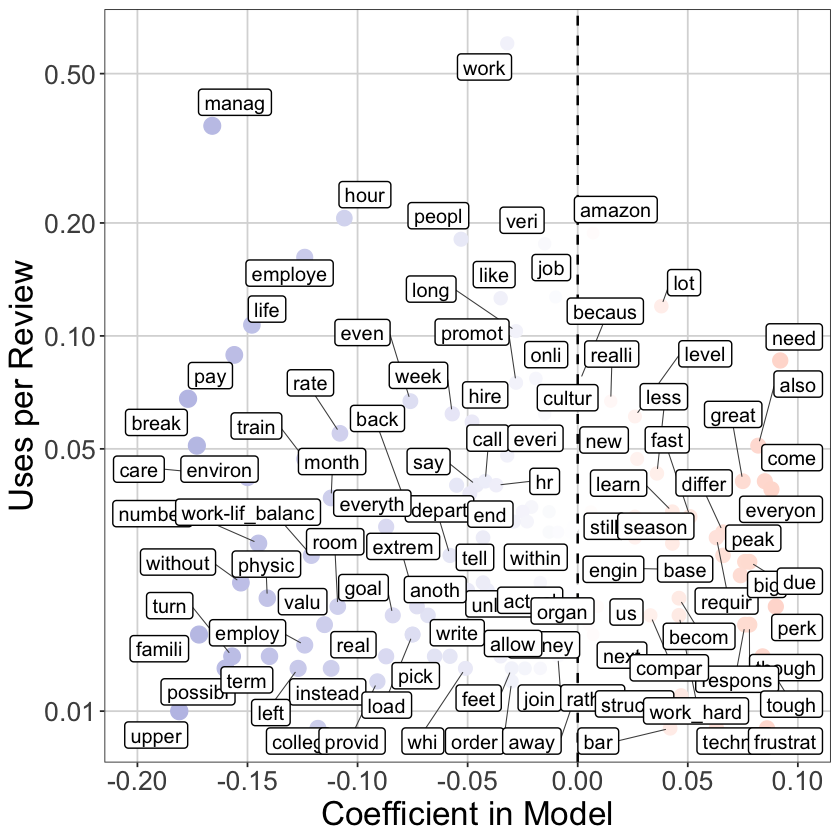

In [171]:
plotDat2 %>%
  ggplot(aes(x = score, y = freq)) +

  # points: keep colourful
  geom_point(aes(color = score, size = abs(score)),
             alpha = 1) +

  scale_color_gradient2(
    low  = "#0050B3",
    mid  = "white",
    high = "#D40000",
    midpoint = 0
  ) +
  scale_size_continuous(range = c(2.5, 6)) +
  guides(size = "none", color = "none") +

  geom_vline(xintercept = 0, linetype = "dashed", linewidth = 0.7) +

  # labels: force readable styling (no colour mapping, no transparency)
  ggrepel::geom_label_repel(
    aes(label = ngram),
    color = "black",        # text colour
    fill  = "white",        # label background
    alpha = 1,              # label opacity
    label.size = 0.4,       # border thickness
    size = 4.2,             # text size (try 4–5)
    box.padding = 0.35,
    point.padding = 0.25,
    segment.color = "grey30",
    segment.size = 0.3,
    max.overlaps = 15
  ) +

  scale_x_continuous(
    limits = c(-.2, .1),
    breaks = seq(-.2, .2, .05)
  ) +
  scale_y_continuous(
    trans = "log2",
    breaks = c(.01, .05, .1, .2, .5, 1, 2, 5)
  ) +

  theme_bw() +
  labs(x = "Coefficient in Model", y = "Uses per Review") +
  theme(
    axis.title = element_text(size = 20),
    axis.text  = element_text(size = 16),
    panel.grid.major = element_line(color = "grey85"),
    panel.grid.minor = element_blank()
  )
